# 📒 MobilePlantViT - AI Crop Disease Detector

## 0. Environment Setup & Library Imports
---

In [1]:
# Install optional libraries (if needed in Colab)
%pip install -q -U keras-tuner
%pip install -q -U tensorboard-plugin-profile

# Reproducibility & Imports
import os, math, json, random, tensorflow as tf
import keras_tuner as kt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable mixed precision (for faster training on Colab GPUs)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Utils
def get_run_logdir(root):
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(root, exist_ok=True)
    return os.path.join(root, stamp)

def cardinality(ds):
    """Best effort steps/epoch for schedules & callbacks."""
    c = tf.data.experimental.cardinality(ds).numpy()
    return None if c < 0 else int(c)

print("TF version:", tf.__version__)

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.14.0 which is incompatible.
s3fs 2024.6.1 requires fsspec==2024.6.1.*, but you have fsspec 2025.12.0 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.2 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ModuleNotFoundError: No module named 'tensorflow_datasets'

## 1. Introduction 🌱
---

Agriculture remains the backbone of rural economies—especially in the Global South—where it employs over **65% of the workforce** in some developing regions (source: digitalplanet.tufts.edu). Yet, farmers continue to face **unpredictable losses due to pests, disease, and climate volatility**. These challenges contribute to a staggering level of food insecurity, affecting an estimated **2.3 billion people globally** (source: publicpolicy.google).

To address this, **deep learning–based diagnostic tools** offer a scalable, data-driven solution. One real-world success story is **Wadhwani AI’s pest detection app** in India, which increased farmer profits by **20%** and reduced pesticide use by **25%** by enabling timely and precise interventions (source: publicpolicy.google). This dual impact—**improved incomes and environmental benefits**—underscores the power of AI in agriculture.

In **Latin America**, the potential is equally transformative:
- A **4-year study in Colombia** showed that ML-guided recommendations based on weather and soil data boosted maize yields from **3.5 to over 6 tons per hectare**—a **~70% increase** (source: eurekalert.org).
- In Chile’s **Biobío region**, AI-powered irrigation systems led to **30% less water use** and **20% higher yields**, demonstrating efficiency gains through resource-aware agriculture (source: developmentaid.org).
- AI-guided precision spraying systems such as **AgZen**, an MIT spinoff, have reduced pesticide volumes by **30–50%** while also **increasing crop yields** via precise targeting and real-time feedback (source: news.mit.edu).

These results show that **AI-based agriculture can deliver double-digit improvements** in both yield and cost efficiency—outcomes that directly support **food security, farmer livelihoods, and environmental sustainability**.

**Project Goal:** This project presents **MobilePlantViT**, a deep learning solution designed for smallholder farmers in Latin America. It uses lightweight CNN or ViT architectures to detect plant diseases from **smartphone images**, enabling **real-time, offline diagnostics** even in low-connectivity environments.

By combining accurate classification with edge deployment, this tool could:
- Prevent crop losses from disease.
- Increase productivity by reducing treatment delay.
- Minimize overuse of agrochemicals.
- Empower millions of farmers with actionable AI.

Ultimately, this system could help unlock significant **yield and income gains**, while reducing the environmental footprint of farming.

## 2. Project Objectives 🎯
---

- **Model:** Train a robust plant-disease classifier with MobileNetV3Small + a shallow head.
- **Data:** Use TFDS PlantVillage with a 70/15/15 train/val/test split and consistent preprocessing.
- **Optimization:** Explore hyperparameters via Bayesian search; track training with TensorBoard.
- **Evaluation:** Report test accuracy, confusion matrix, and per-class metrics (precision/recall/F1).
- **Deployment:** Convert the best Keras model to TFLite (with quantization options) for mobile.
- **Usability:** Ship a tiny Streamlit demo to try single-image inference interactively.

## 3. Dataset Loading & Preprocessing
---

- **Splits:** train(70%), train(70%:85%) - validation, train(85%:) - test.
- **Image size:** 224×224 (matches MobileNetV3 default for good accuracy/speed trade-off).
- **Preprocessing:** `tf.keras.applications.mobilenet_v3.preprocess_input` maps `uint8` images to the scale expected by the pretrained backbone.
- **Pipeline:** map → shuffle → batch → prefetch with `tf.data.AUTOTUNE` to keep the accelerator fed.
- **Bookkeeping:** compute `STEPS_PER_EPOCH/VAL_STEPS` using cardinality(ds) for schedules/callbacks.

In [ ]:
# Load dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 224
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
NUM_CLASSES = ds_info.features['label'].num_classes

# Preprocess function
def format_image(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.keras.applications.mobilenet_v3.preprocess_input(tf.cast(image, tf.float32))
  return image, label

# Apply mapping, caching, batching, prefetching
def prepare(ds):
  return (ds
          .map(format_image, num_parallel_calls=AUTO)
          .shuffle(1000)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

ds_train = prepare(ds_train)
ds_val = prepare(ds_val)
ds_test = prepare(ds_test)

STEPS_PER_EPOCH = cardinality(ds_train)
VAL_STEPS = cardinality(ds_val)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.HBRPOI_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


I0000 00:00:1760396444.693868      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760396444.694509      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## 4. Dataset Visualization & Class Balance
---

- **Sample gallery:** visualize a few training images with their labels to catch anomalies (wrong channels/orientation, unexpected backgrounds, etc.).
- **Class histogram:** plot label counts to spot imbalance.

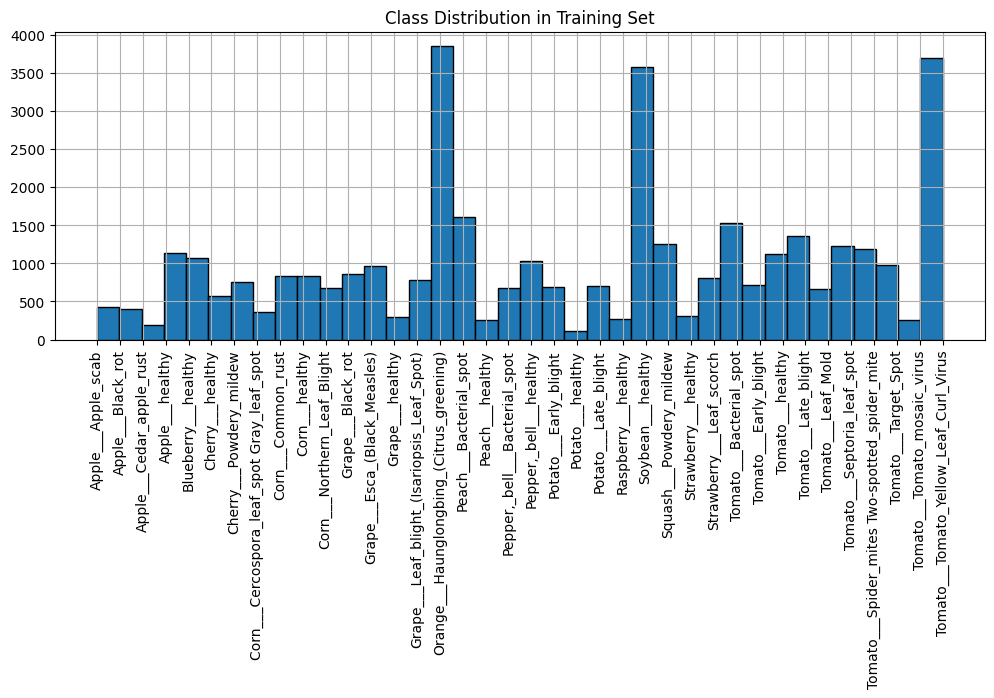

In [ ]:
class_names = ds_info.features['label'].names

# Class distribution histogram
labels = []
for _, label in tfds.as_numpy(ds_train.unbatch()):
  labels.append(label)

plt.figure(figsize=(12, 4))
plt.hist(labels, bins=len(class_names), edgecolor='k')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.title("Class Distribution in Training Set")
plt.grid(True)
plt.show()

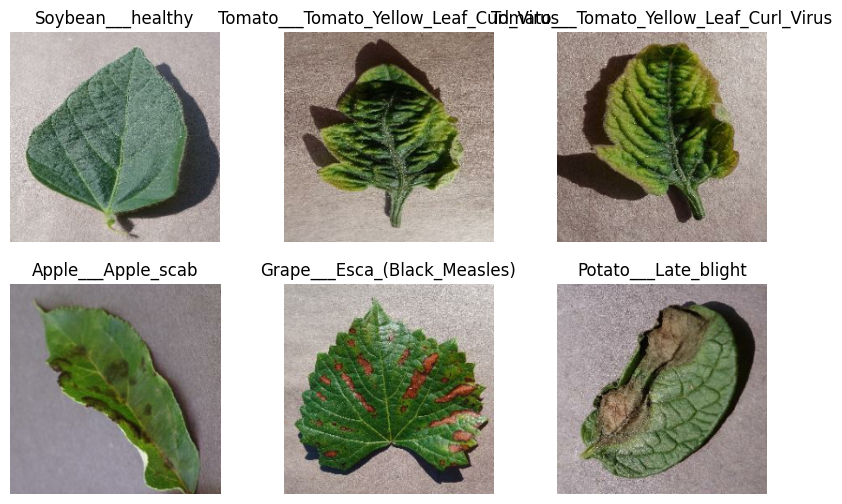

In [ ]:
# Sample images
def format_image_for_visualization(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

ds_plot = ds_train.map(format_image_for_visualization)

plt.figure(figsize=(10, 6))
for images, labels in ds_plot.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 5. Model Architecture (MobileNetV3Small)
---

Full classifier.

- **Backbone:** MobileNetV3Small(`include_top=False`, `weights="imagenet"`) as a feature extractor.
- **Augmentations:** lightweight, on-the-fly transforms (flip, rotation, zoom, contrast) for robustness.
- Head: GAP → Dropout → Dense (no bias) → BatchNorm → Activation → final Dense(`NUM_CLASSES`, softmax in `float32`).
- Fine-tuning controls:
  - `phase="head"` freezes the backbone (train only the head).
  - `phase="ft"` optionally unfreezes the last N layers (via unfreeze_last_n) to adapt features.
  - `bn_train_in_ft`: runs BN layers in training mode during FT for stable updates.

Optimization.

- **Optimizer:** AdamW with weight decay for better generalization.
- **Schedule:** custom Warmup + Cosine decay (WarmupCosine) parameterized by steps/epoch and total steps. One epoch of warmup is used by default.

MobileNetV3Small is tiny and efficient, ideal for TFLite. The head keeps FP32 numerics at the output (good with mixed precision). Warmup stabilizes the early steps; cosine decay provides smooth long-term convergence.

In [ ]:
# Reusable data augmentation layer
def make_augmentation_layer(use_aug=True):
  if not use_aug:
      return tf.keras.Sequential([tf.keras.layers.Activation('linear')], name="no_aug")
  return tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.15, 0.15),
      tf.keras.layers.RandomContrast(0.15),
  ], name="aug")

In [ ]:
# LR schedules (warmup + cosine)
from keras.saving import register_keras_serializable

@register_keras_serializable(package="lr_schedules")   # <-- registers the name
class WarmupCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, min_lr, warmup_steps, total_steps):
        super().__init__()
        self.base_lr = float(base_lr)
        self.min_lr = float(min_lr)
        self.warmup_steps = int(warmup_steps)
        self.total_steps = int(max(self.warmup_steps + 1, int(total_steps)))

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm_lr = self.base_lr * (step + 1.0) / float(self.warmup_steps)
        progress = tf.clip_by_value(
            (step - self.warmup_steps) / tf.maximum(1.0, (self.total_steps - self.warmup_steps)), 0.0, 1.0
        )
        pi_const = tf.constant(math.pi, dtype=tf.float32)
        cosine = 0.5 * (1.0 + tf.cos(pi_const * progress))
        decayed = self.min_lr + (self.base_lr - self.min_lr) * cosine
        return tf.where(step < self.warmup_steps, warm_lr, decayed)

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "min_lr": self.min_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
# Model factory used by the tuner (and standalone)
def build_finetune_model(hp, steps_per_epoch=None, epochs=10, phase="head", bn_train_in_ft=True):
    """
    phase: "head" for head-only training, "ft" for fine-tuning
    """
    # Hyperparameters
    use_aug = hp.Boolean("use_data_augmentation", default=True)
    trainable_base = hp.Boolean("trainable_base_model", default=False)
    dense_units = hp.Int("dense_units", 128, 256, step=64, default=128)
    dropout_rate = hp.Float("dropout", 0.1, 0.3, step=0.1, default=0.2)
    activation_choice = hp.Choice("activation", ["relu", "swish"], default="relu")

    # Optimizer & schedule
    base_lr = hp.Choice("learning_rate", [1e-3, 3e-4, 1e-4], default=3e-4)
    weight_decay = hp.Float("weight_decay", 1e-5, 5e-5, sampling="log", default=5e-5)

    # How deep to unfreeze when trainable_base=True (used in phase "ft")
    unfreeze_last_n = hp.Int("unfreeze_last_n_layers", 30, 90, step=15, default=60)

    # ---------- Base & augmentation ----------
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights="imagenet",
        name="backbone"
    )
    base_model.trainable = trainable_base if phase == "ft" else False  # TODO: CHECK THIS AND THE FOLLOWING CONDITIONAL!!!

    if base_model.trainable and phase == "ft":
        # Freeze all, then unfreeze last N layers for stability
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    aug = make_augmentation_layer(use_aug=use_aug)


    # Head: GAP -> Dropout -> Dense(no bias) -> BN -> Activation
    inp = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = aug(inp)
    x = base_model(x, training=(phase == "ft" and bn_train_in_ft))  # Use batch-norm in training mode only during fine-tuning
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # kernel init matched to activation
    kernel_init = "he_normal" if activation_choice == "relu" else "glorot_uniform"
    x = tf.keras.layers.Dense(
        dense_units, use_bias=False,
        kernel_initializer=kernel_init,
        # kernel_regularizer=tf.keras.regularizers.L2(weight_decay),
        dtype="float32"  # keep head math in fp32
    )(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(
        tf.keras.activations.relu if activation_choice == "relu" else tf.keras.activations.swish
    )(x)

    out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    model = tf.keras.Model(inp, out)

    # ---------- Optimizer with warmup+cosine ----------
    if steps_per_epoch is None:
        # Fallback if cardinality unknown
        steps_per_epoch = 100

    warmup_steps = 1 * steps_per_epoch  # 1 epoch warmup by default
    total_steps = epochs * steps_per_epoch
    min_lr = 1e-6 if phase == "head" else 3e-6  # slightly higher floor in head phase
    lr_schedule = WarmupCosine(
        base_lr=base_lr if phase == "head" else base_lr * 0.1,
        min_lr=min_lr,
        warmup_steps=warmup_steps if phase == "head" else max(1, int(0.2 * steps_per_epoch)),
        total_steps=total_steps
    )

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=weight_decay
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=["accuracy"]
    )
    
    return model

## 6. Training the Model
---

Trains a fixed configuration (head-only by default) with standard callbacks:

- **Callbacks:** TensorBoard (training curves), EarlyStopping on val_loss with `restore_best_weights=True`, and `ModelCheckpoint` to persist the best epoch.
- **Fit:** `model.fit(ds_train, validation_data=ds_val, ...)` for a small number of epochs, then evaluate on ds_test.

This step takes about 10-15 minutes on a GPU and can be monitored with `%tensorboard`.

In [ ]:
# Build fix hp object to train a single model
hp_fixed = kt.HyperParameters()
hp_fixed.Fixed("use_data_augmentation", True)
hp_fixed.Fixed("trainable_base_model", False)      # phase="head", base frozen
hp_fixed.Fixed("dense_units", 128)
hp_fixed.Fixed("dropout", 0.2)
hp_fixed.Fixed("activation", "relu")
hp_fixed.Fixed("learning_rate", 3e-4)
hp_fixed.Fixed("weight_decay", 5e-5)
hp_fixed.Fixed("label_smoothing", 0.1)
hp_fixed.Fixed("unfreeze_last_n_layers", 60)       # only used in phase="ft"

# Define callbacks
log_dir = get_run_logdir("logs/model_training/")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)

# Build the model
model = build_finetune_model(
  hp_fixed, steps_per_epoch=STEPS_PER_EPOCH, epochs=10, phase="head"
)

# Train -> 15 min
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb]
)

Epoch 1/15


I0000 00:00:1760397381.540804     364 cuda_dnn.cc:529] Loaded cuDNN version 90300


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.2269 - loss: 3.1500 - val_accuracy: 0.7762 - val_loss: 0.9166
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.7914 - loss: 0.8520 - val_accuracy: 0.8844 - val_loss: 0.4105
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8761 - loss: 0.4589 - val_accuracy: 0.9126 - val_loss: 0.2920
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.8993 - loss: 0.3400 - val_accuracy: 0.9198 - val_loss: 0.2547
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.9115 - loss: 0.2957 - val_accuracy: 0.9331 - val_loss: 0.2153
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.9179 - loss: 0.2682 - val_accuracy: 0.9351 - val_loss: 0.2047
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.9206 - loss: 0.2542 - val_accuracy: 0.9389 - val_loss: 0.1911
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.9252 - loss: 0.24

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9466 - loss: 0.1725
Test Loss: 0.18070460855960846
Test Accuracy: 0.9432780742645264


## 7. Hyperparameter Tuning (Bayesian Optimization)
---

Uses Keras Tuner (Bayesian) to explore a compact search space:

- **Search dimensions (examples):** use/not use augmentation, freeze/unfreeze base, dense_units, dropout, activation (relu/swish), LR, and how many layers to unfreeze during fine-tuning.
- **Objective:** maximize val_accuracy under an early-stopping regime.
- **Artifacts:** saves best checkpoints and logs to TensorBoard; retrieves best_model and best_hps for later use/testing.

In [ ]:
# Keras Tuner (Bayesian) for the HEAD phase only
class HeadHyperModel(kt.HyperModel):
  def build(self, hp):
      return build_finetune_model(hp, steps_per_epoch=STEPS_PER_EPOCH, epochs=10, phase="ft")

  def fit(self, hp, model, *args, **kwargs):
      return model.fit(*args, **kwargs)

tuner = kt.BayesianOptimization(
  HeadHyperModel(),
  objective="val_accuracy",
  seed=42,
  max_trials=10,
  alpha=1e-4,
  beta=2.6,
  overwrite=True,
  directory="bayesian_project",
  project_name="image_fine_tuning"
)

log_dir = get_run_logdir("logs/hparam_tuning/")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
# Save only the best model (highest val_accuracy)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model_tunned.keras",        # filename to save
    monitor="val_accuracy",             # metric to monitor
    save_best_only=True,                # keep only the best epoch
    save_weights_only=False,            # save full model (architecture + weights + optimizer)
    mode="max",                         # 'max' because higher accuracy = better
    verbose=1
)

tuner.search(
  ds_train,
  validation_data=ds_val,
  epochs=10,
  callbacks=[early_stopping_cb, tensorboard_cb, checkpoint_cb]
)

Trial 10 Complete [00h 05m 58s]
val_accuracy: 0.9512644410133362

Best val_accuracy So Far: 0.9716424942016602
Total elapsed time: 01h 03m 27s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(json.dumps(best_hps.values, indent=4))

# Evaluate
test_loss, test_acc = best_model.evaluate(ds_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Best hyperparameters:
{
    "use_data_augmentation": false,
    "trainable_base_model": false,
    "dense_units": 256,
    "dropout": 0.1,
    "activation": "swish",
    "learning_rate": 0.001,
    "weight_decay": 1.8959758537443146e-05,
    "unfreeze_last_n_layers": 30
}
255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9706 - loss: 0.1014
Test loss: 0.10191376507282257
Test accuracy: 0.971270740032196


In [ ]:
# Save the tuned best model
best_model.save("best_model_tuned.keras")
best_model.save_weights("best_model_tuned.weights.h5")

## 8. Evaluation & Confusion Matrix
---

Evaluates generalization and error patterns:

- **Single-sample sanity check:** run one image through best_model and compare predicted vs. true class to confirm label order and preprocessing.
- **Full test evaluation:** compute overall test accuracy on ds_test.
- **Confusion matrix:** visualize per-class confusions; rows (true) vs columns (pred).
- **Classification report:** precision, recall, F1 per class (+ macro/weighted averages) in a tidy `pandas.DataFrame`.
- **Learning-rate tracking & curve plots:**
  - Plot train/val accuracy & loss.
  - Show the generalization gap per epoch.
  - Overlay the effective LR per epoch to correlate schedule and convergence.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs/hparam_tuning

In [ ]:
# Get one batch (a tuple of (images, labels)), each item yielded by ds_test is a batch, meaning a tuple: (images, labels)
for images, labels in ds_test.take(1):
    image = images[0]
    label = labels[0]
    break

img_batch = tf.expand_dims(image, axis=0)  # shape becomes (1, 224, 224, 3)
pred = best_model.predict(img_batch)  # shape becomes (1, 10)
predicted_class = np.argmax(pred, axis=1)[0]

class_names = ds_info.features['label'].names
print("Predicted:", class_names[predicted_class])
print("True label:", class_names[label.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
True label: Tomato___Tomato_Yellow_Leaf_Curl_Virus


255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9712 - loss: 0.0997
✅ Test Accuracy: 97.13%


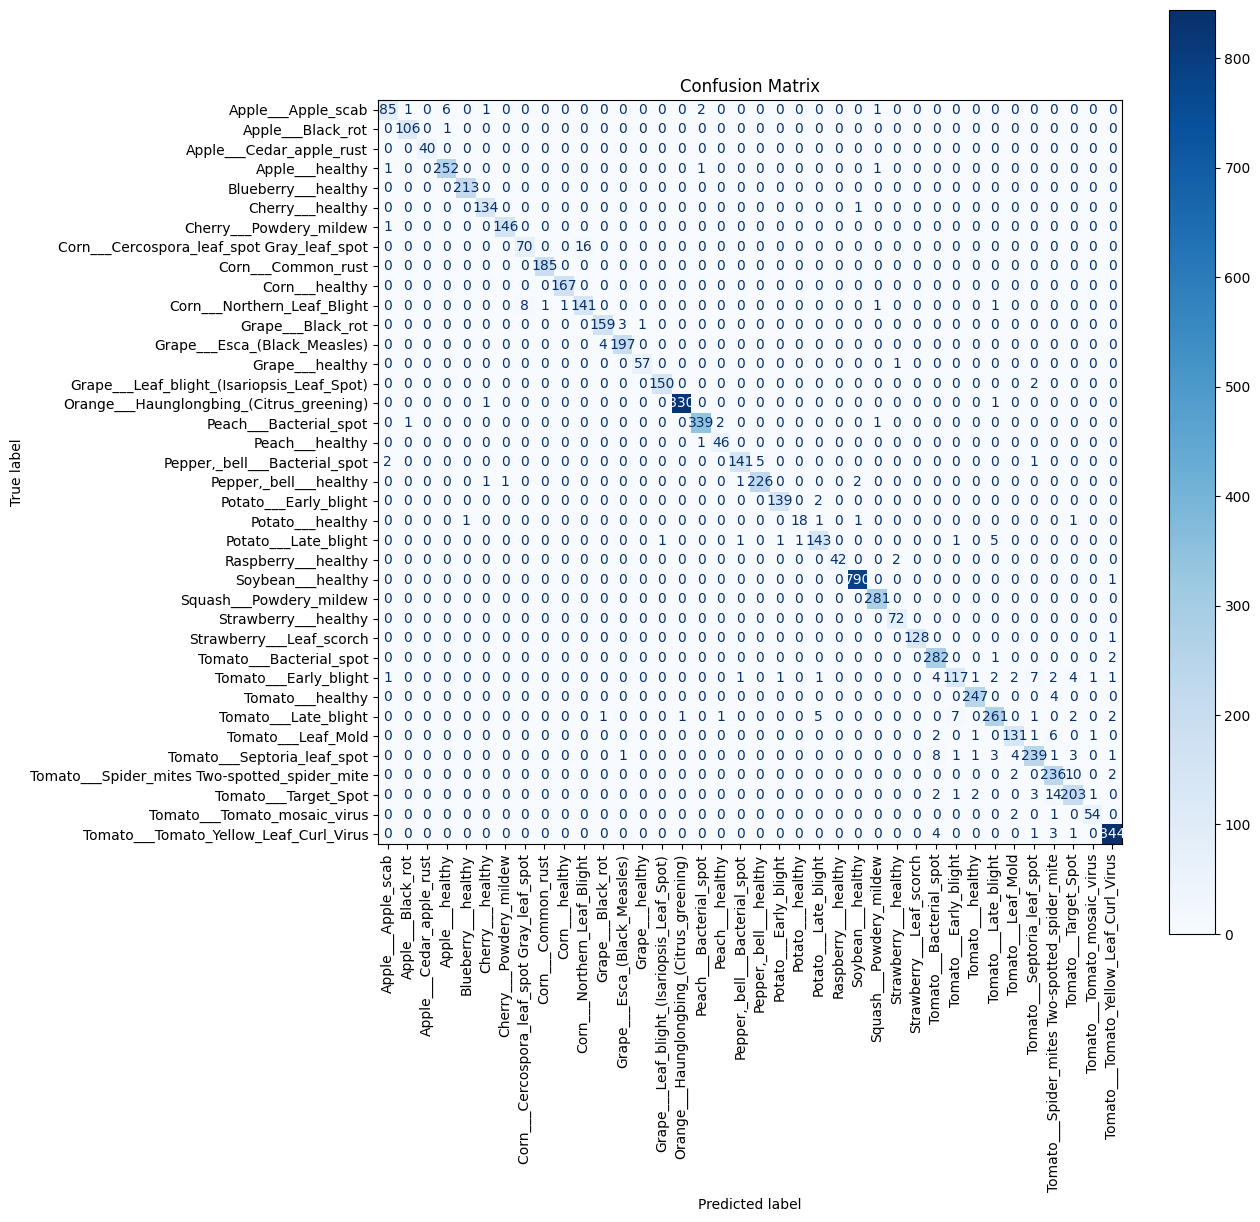

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# Evaluate
test_loss, test_acc = best_model.evaluate(ds_test)
print(f"✅ Test Accuracy: {test_acc:.2%}")

# Predict on test set
y_true, y_pred = [], []
for images, labels in ds_test:
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
df_report = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).T
df_report

,precision,recall,f1-score,support
Apple___Apple_scab,0.944444,0.885417,0.913978,96.000000
Apple___Black_rot,0.981481,0.990654,0.986047,107.000000
Apple___Cedar_apple_rust,1.000000,1.000000,1.000000,40.000000
Apple___healthy,0.972973,0.988235,0.980545,255.000000
Blueberry___healthy,0.995327,1.000000,0.997658,213.000000
Cherry___healthy,0.978102,0.992593,0.985294,135.000000
Cherry___Powdery_mildew,0.993197,0.993197,0.993197,147.000000
Corn___Cercospora_leaf_spot Gray_leaf_spot,0.897436,0.813953,0.853659,86.000000
Corn___Common_rust,0.994624,1.000000,0.997305,185.000000
Corn___healthy,0.994048,1.000000,0.997015,167.000000


In [ ]:
# --- callback to record the effective learning rate at the end of each epoch ---
class RecordLR(tf.keras.callbacks.Callback):
    """Records the effective learning rate at each epoch end.
    Works with constant LR, tf/keras schedules, and custom callables.
    """
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate  # could be float/var/schedule/callable
        try:
            # If it's a schedule or any callable, evaluate it at current step.
            if callable(lr_obj):
                lr = lr_obj(self.model.optimizer.iterations)
            else:  # float or tf.Variable
                lr = lr_obj
            lr = tf.keras.backend.get_value(lr)
        except Exception:
            # Last-ditch fallback: read as a plain scalar
            lr = float(tf.keras.backend.get_value(getattr(self.model.optimizer, "learning_rate")))
        self.lrs.append(float(lr))


# --- nice plotting helper ---
def plot_learning_curves(history, lr_per_epoch=None, save_prefix=None):
    h = history.history
    epochs = np.arange(1, len(h["loss"]) + 1)

    # 1) Loss
    plt.figure()
    plt.plot(epochs, h["loss"], label="train")
    plt.plot(epochs, h["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_loss.png", dpi=160)
    plt.show()

    # 2) Accuracy (if present)
    if "accuracy" in h and "val_accuracy" in h:
        plt.figure()
        plt.plot(epochs, h["accuracy"], label="train")
        plt.plot(epochs, h["val_accuracy"], label="val")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
        plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
        if save_prefix: plt.savefig(f"{save_prefix}_acc.png", dpi=160)
        plt.show()

        # Generalization gap
        gap = np.array(h["accuracy"]) - np.array(h["val_accuracy"])
        plt.figure()
        plt.plot(epochs, gap)
        plt.axhline(0, linewidth=1, linestyle="--")
        plt.xlabel("Epoch"); plt.ylabel("Train − Val accuracy")
        plt.title("Generalization gap"); plt.grid(alpha=.3); plt.tight_layout()
        if save_prefix: plt.savefig(f"{save_prefix}_gap.png", dpi=160)
        plt.show()

    # 3) Learning rate per epoch
    if lr_per_epoch is not None and len(lr_per_epoch) == len(epochs):
        plt.figure()
        plt.plot(epochs, lr_per_epoch)
        plt.xlabel("Epoch"); plt.ylabel("Learning rate"); plt.title("LR schedule")
        plt.yscale("log"); plt.grid(alpha=.3); plt.tight_layout()
        if save_prefix: plt.savefig(f"{save_prefix}_lr.png", dpi=160)
        plt.show()

Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9656 - loss: 0.1305 - val_accuracy: 0.9730 - val_loss: 0.0944
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9679 - loss: 0.1179 - val_accuracy: 0.9743 - val_loss: 0.0873
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.9711 - loss: 0.1035 - val_accuracy: 0.9761 - val_loss: 0.0805
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.9740 - loss: 0.0953 - val_accuracy: 0.9769 - val_loss: 0.0763
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9757 - loss: 0.0872 - val_accuracy: 0.9784 - val_loss: 0.0717
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9762 - loss: 0.0815 - val_accuracy: 0.9788 - val_loss: 0.0694
Epoch 7/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.9784 - loss: 0.0760 - val_accuracy: 0.9791 - val_loss: 0.0672
Epoch 8/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9775 -

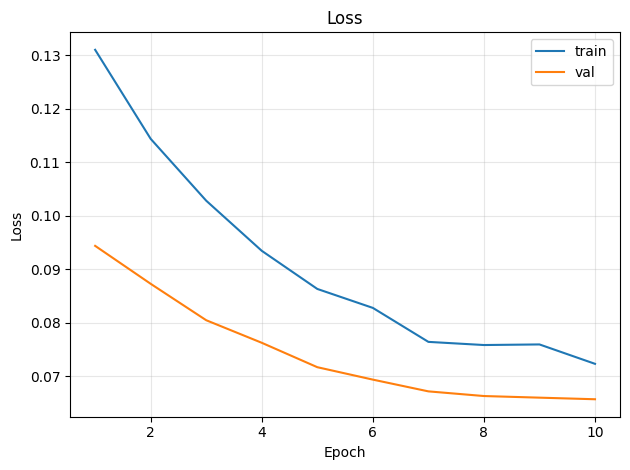

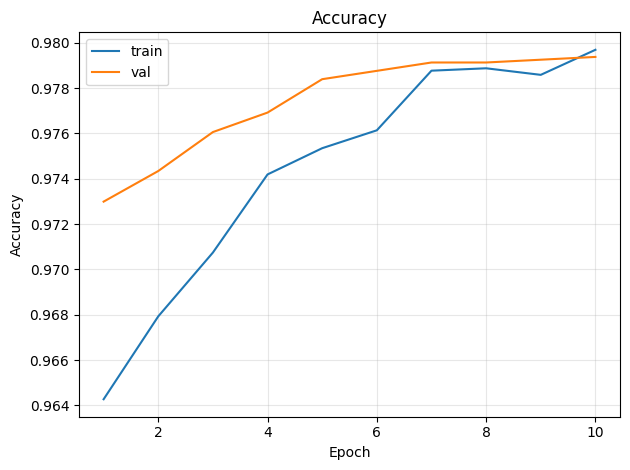

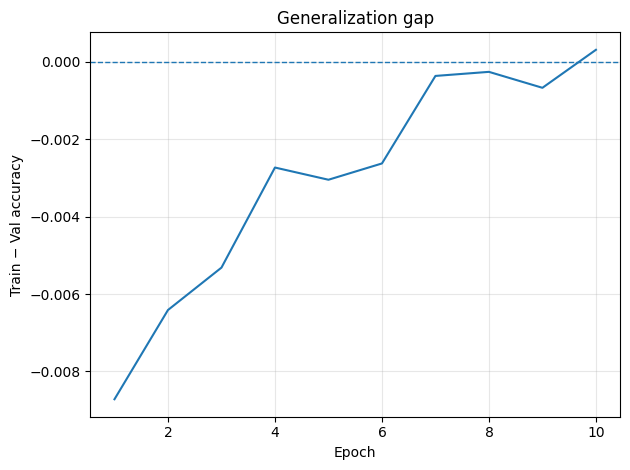

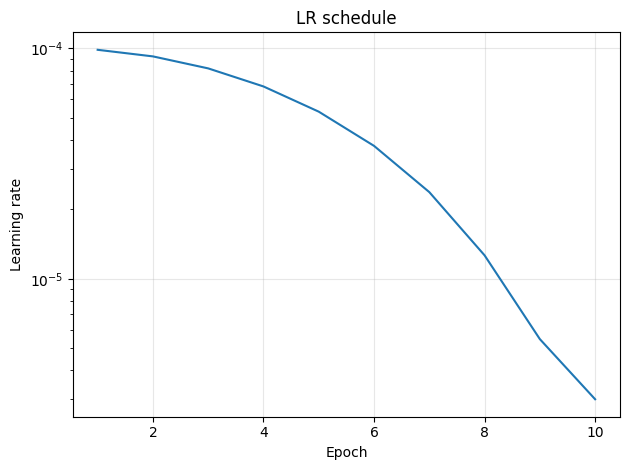

In [ ]:
EPOCHS = 10  # or any value you want to visualize

lr_cb = RecordLR()
history = best_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[early_stopping_cb, lr_cb, tensorboard_cb]  # you can include checkpoint_cb too
)

plot_learning_curves(history, lr_per_epoch=lr_cb.lrs, save_prefix="best_model_learning_curves")

## 9. Save & Load Model
---

In [ ]:
# Save model
best_model.save('best_model_tuned.keras')

# Load model
best_model = tf.keras.models.load_model(
    '/kaggle/input/ai-crop-disease-prediction/keras/default/1/best_model_tunned.keras',
    custom_objects={"lr_schedules>WarmupCosine": WarmupCosine},
    compile=False,
    safe_mode=True
)

## 11. Conclusion & Future Work
---

- Project impact: offers an offline-capable, AI-driven diagnostic tool for crop diseases with potential to reduce yield losses, promote sustainable farming, and improve smallholder livelihoods.

- Extension ideas:

  - Fine-tune on region-specific diseases and crops.
  - Incorporate active learning to allow users to submit new disease samples.
  - Add local language advisory and treatment suggestions.
  - Deploy fully on-device via Android app or integrate into field extension workflows.

- Research relevance: aligned with global efforts to use deep learning for crop protection—where lightweight models like EfficientNetB0 and MobileViT outperform heavier nets with strong generalizability and mobile suitability

*Juan Esteban Rozo Urbina | Bogota, Colombia* 🇨🇴